<a href="https://colab.research.google.com/github/bs3537/DS-Unit-2-Linear-Models/blob/master/Bhav_multiple_regression_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [0]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#Let us exclude non-numeric columns from dataset
df2 = df.select_dtypes(include='number')

In [0]:
df2.head()

,bathrooms,bedrooms,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,40.7145,-73.9425,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,40.7947,-73.9667,5465,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,40.7388,-74.0018,2850,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,40.7539,-73.9677,3275,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,40.8241,-73.9493,3350,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#convert negative number to absolute numbers
df3 = df2.abs()

In [0]:
df3.head()

,bathrooms,bedrooms,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3.0,40.7145,73.9425,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2.0,40.7947,73.9667,5465.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,40.7388,74.0018,2850.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,40.7539,73.9677,3275.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,4.0,40.8241,73.9493,3350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#find null values
df3.isnull().sum()

bathrooms               0
bedrooms                0
latitude                0
longitude               0
price                   0
elevator                0
cats_allowed            0
hardwood_floors         0
dogs_allowed            0
doorman                 0
dishwasher              0
no_fee                  0
laundry_in_building     0
fitness_center          0
pre-war                 0
laundry_in_unit         0
roof_deck               0
outdoor_space           0
dining_room             0
high_speed_internet     0
balcony                 0
swimming_pool           0
new_construction        0
terrace                 0
exclusive               0
loft                    0
garden_patio            0
wheelchair_access       0
common_outdoor_space    0
dtype: int64

In [0]:
df3.shape

(48817, 29)

Split dataset into train and test datasets

In [0]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [0]:
# create training and test datasets
# create training and testing vars
train, test = train_test_split(df3, test_size=0.2, random_state = 0)

In [0]:
train.shape

(39053, 29)

In [0]:
test.shape

(9764, 29)

Begin with baselines,, zero features

In [0]:
train['price'].mean()

3578.6967710547206

In [0]:
from sklearn.metrics import mean_absolute_error

# Arrange y target vectors
target = 'price'
y_train = train[target]
y_test = test[target]

# Get mean baseline
print('Mean Baseline (using 0 features)')
guess = y_train.mean()

# Train Error
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error (NYC rent): {mae:.2f} USD')

# Test Error
y_pred = [guess] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error (NYC rent): {mae:.2f} USD')

Mean Baseline (using 0 features)
Train Error (NYC rent): 1199.02 USD
Test Error (NYC rent): 1210.35 USD


Exploring relationship of price with one variable

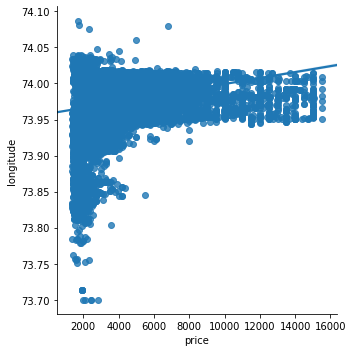

In [0]:
import pandas as pd
import seaborn as sns
sns.lmplot(data=X_train, x="price", y="longitude")


Linear regression with a single variable 

In [0]:
# 1. Import the appropriate estimator class from Scikit-Learn
from sklearn.linear_model import LinearRegression

# 2. Instantiate this class
model = LinearRegression()

# 3. Arrange X features matrices (already did y target vectors)
features = ['longitude']
X_train = train[features]
X_test = test[features]
print(f'Linear Regression, dependent on: {features}')

# 4. Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error: {mae:.2f} USD')

# 5. Apply the model to new data
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error: {mae:.2f} USD')

Linear Regression, dependent on: ['longitude']
Train Error: 1141.55 USD
Test Error: 1153.83 USD


####Thus, both train error and test error are lower after including a single variable, longitude which appears to have a linear relationship with price on the seaborn plot.


Now, let us do linear regression including two variables, longitude and latitude

In [0]:
from sklearn.preprocessing import StandardScaler


# Re-arrange X features matrices
features = ['longitude', 
            'latitude']
print(f'Linear Regression, dependent on: {features}')
X_train = train[features]
X_test = test[features]

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the model
model.fit(X_train_scaled, y_train)
y_pred_train = model.predict(X_train_scaled)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f'Train error: {mae_train:.2f} USD')

# Apply the model to new data
y_pred_test = model.predict(X_test_scaled)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'Test error: {mae_test:.2f} USD')

Linear Regression, dependent on: ['longitude', 'latitude']
Train error: 1143.85 USD
Test error: 1155.20 USD


By including latitude, our train and test errors are higher than just univariate linear regression with longitude, so latitude is not a good feature

Let us try including some other features like bedrooms, bathrooms, pets allowed or not, terrace etc. since these are theoretically expected to have a relationship with rent. 

In [0]:
from sklearn.preprocessing import StandardScaler


# Re-arrange X features matrices
features = ['bathrooms', 
            'bedrooms',
            'longitude',
            'latitude',
            'terrace',
            'swimming_pool',
            'dogs_allowed',
            'cats_allowed',
            'elevator',
            'fitness_center',
            'pre-war',
            'laundry_in_unit',
            'roof_deck',
            'high_speed_internet',
            'doorman',
            'loft',
            'garden_patio',
            'no_fee']
print(f'Linear Regression, dependent on: {features}')
X_train = train[features]
X_test = test[features]

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the model
model.fit(X_train_scaled, y_train)
y_pred_train = model.predict(X_train_scaled)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f'Train error: {mae_train:.2f} USD')

# Apply the model to new data
y_pred_test = model.predict(X_test_scaled)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'Test error: {mae_test:.2f} USD')

Linear Regression, dependent on: ['bathrooms', 'bedrooms', 'longitude', 'latitude', 'terrace', 'swimming_pool', 'dogs_allowed', 'cats_allowed', 'elevator', 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck', 'high_speed_internet', 'doorman', 'loft', 'garden_patio', 'no_fee']
Train error: 700.97 USD
Test error: 703.18 USD


Thus, our multivariate regression model was able to significantly reduce the train and test errors from zero feature and single feature by including multiple features which are expected to have a relationship with the apartment rent. 

Get the model's coefficients and intercept.

In [0]:
print("Model Intercept", model.intercept_)

Model Intercept 3578.6967710546814


In [0]:
print("Model Coefficients", model.coef_)
#The output has multiple coefficients since we included 18 features in our linear regression model.

Model Coefficients [852.14279879 529.05705244 387.55568763  66.52495951  21.24624212
  16.81817964  77.04867757 -33.89605173  49.43010647  51.05463895
 -13.98904173 163.48425463 -53.24357465 -92.79853782 246.90129258
  24.14842841   8.84573754 -98.46589881]


In [0]:
#Features in the model = 
#numerical variables = number of bathrooms, number of bedrooms, longitude, latitude
#categorical variables (1=yes, 0 =no): terrace, swimming pool, dog allowed, cats allowed, elevator, 
#                                      fitness center, pre-war, laundry in the unit, roof deck, high speed internet, 
#                                      doorman, loft, garden patio, no fee. 


In [0]:
#Testing the model #with terrace and swimming pool and fitness center, 2 bedrooms and 1 bathroom
model.predict([[1, 2, 73.9425, 40.7145, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0]])

array([37456.56729824])

In [0]:
#Testing the model #with terrace and swimming pool and fitness center, 3 bedrooms and 2 bathrooms
model.predict([[2, 3, 73.9425, 40.7145, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0]])

array([38837.76714946])

In [0]:
#Testing the model with 1 bedroom, 1 bathroom and no swimming pool, terrace or fitness center and not pre-war and different location by longitude and latitude.
model.predict([[1, 1, 73.9667, 40.7947, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]])

array([36620.19308363])

Get regression metrics RMSE, MAE, and  R2 , for both the train and test data

In [0]:
#Train data
import statsmodels.api as sm # import statsmodels 

X = X_train_scaled ## X usually means our input variables (or independent variables)
y = y_train ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     3419.
Date:                Sat, 02 Nov 2019   Prob (F-statistic):               0.00
Time:                        03:29:12   Log-Likelihood:            -3.2876e+05
No. Observations:               39053   AIC:                         6.576e+05
Df Residuals:                   39034   BIC:                         6.577e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3578.6968      5.547    645.215      0.000    3567.825    3589.568
x1           852.1428      6.766    125.941      0.000     838.881     865.405
x2           529.0571      6.759     78.277      0.000     515.810     542.305
x3           387.5557      6.179     62.725      0.000     375.445     399.666
x4            66.5250      5.923     11.232      0.000      54.916      78.133
x5            21.2462      6.203      3.425      0.001       9.088      33.405
x6            16.8182      6.051      2.780      0.005       4.959      28.677
x7            77.0487     15.944      4.833      0.000      45.799     108.299
x8           -33.8961     15.924     -2.129      0.033     -65.107      -2.686
x9            49.4301      7.200      6.866      0.000      35.318      63.542
x10           51.0546      7.755      6.584      0.000      35.855      66.254
x11          -13.9890      5.623     -2.488      0.013     -25.011      -2.967
x12          163.4843      6.053     27.011      0.000     151.621     175.347
x13          -53.2436      7.007     -7.598      0.000     -66.978     -39.509
x14          -92.7985      6.653    -13.949      0.000    -105.838     -79.759
x15          246.9013      8.178     30.190      0.000     230.872     262.931
x16           24.1484      5.664      4.263      0.000      13.047      35.250
x17            8.8457      6.134      1.442      0.149      -3.178      20.870
x18          -98.4659      6.171    -15.956      0.000    -110.562     -86.370
==============================================================================
Omnibus:                    21547.040   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           427297.082
Skew:                           2.237   Prob(JB):                         0.00
Kurtosis:                      18.575   Cond. No.                         7.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The output above gives R2 = 0.612, so 61.2% of the variance in rent price is explained by our multivariate linear regression model.
The output summary for the model also gives us the constant 3578.69 which is the model intercept.
The output summary for the model also gives us all the 18 coefficients for the 18 different variables that we selected. 

In [0]:
#Model summary for test dataset
X1 = X_test_scaled ## X usually means our input variables (or independent variables)
y1 = y_pred_test ## Y usually means our output/dependent variable
X1 = sm.add_constant(X1) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y1, X1).fit() ## sm.OLS(output, input)
predictions = model.predict(X1)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.451e+31
Date:                Sat, 02 Nov 2019   Prob (F-statistic):               0.00
Time:                        03:49:09   Log-Likelihood:             2.3756e+05
No. Observations:                9764   AIC:                        -4.751e+05
Df Residuals:                    9745   BIC:                        -4.749e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3578.6968   6.66e-14   5.37e+16      0.000    3578.697    3578.697
x1           852.1428   8.07e-14   1.06e+16      0.000     852.143     852.143
x2           529.0571   8.16e-14   6.49e+15      0.000     529.057     529.057
x3           387.5557   7.51e-14   5.16e+15      0.000     387.556     387.556
x4            66.5250   6.99e-14   9.52e+14      0.000      66.525      66.525
x5            21.2462   7.62e-14   2.79e+14      0.000      21.246      21.246
x6            16.8182    7.1e-14   2.37e+14      0.000      16.818      16.818
x7            77.0487   1.92e-13   4.01e+14      0.000      77.049      77.049
x8           -33.8961   1.92e-13  -1.76e+14      0.000     -33.896     -33.896
x9            49.4301   8.61e-14   5.74e+14      0.000      49.430      49.430
x10           51.0546   9.23e-14   5.53e+14      0.000      51.055      51.055
x11          -13.9890   6.65e-14   -2.1e+14      0.000     -13.989     -13.989
x12          163.4843   7.16e-14   2.28e+15      0.000     163.484     163.484
x13          -53.2436   8.48e-14  -6.28e+14      0.000     -53.244     -53.244
x14          -92.7985    7.9e-14  -1.17e+15      0.000     -92.799     -92.799
x15          246.9013   9.92e-14   2.49e+15      0.000     246.901     246.901
x16           24.1484   6.99e-14   3.45e+14      0.000      24.148      24.148
x17            8.8457   7.74e-14   1.14e+14      0.000       8.846       8.846
x18          -98.4659   7.39e-14  -1.33e+15      0.000     -98.466     -98.466
==============================================================================
Omnibus:                     1649.636   Durbin-Watson:                   1.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2780.997
Skew:                           1.119   Prob(JB):                         0.00
Kurtosis:                       4.353   Cond. No.                         7.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

####R2 for the test dataset is 1, so 100% of the variance in rent in test dataset is explained by our multivariate regression model. Thus, our multivariate linear regression has 100% predictive accuracy in predicting rent in the test dataset. That is a good result.

In machine learning, the test data accuracy is more important, so my multiple regression model has 100% predictive accuracy.

I also played around with some other variables but was unable to get R2 of higher than 61.2% in train dataset. I would prefer >70% for train dataset but for this dataset, I can't get higher R2 in train data.